# TUD IS sentiment analysis
This notebook contains first expereriments for Sentiment Analysis of Tweets from the Twitter-API with the Google Natural Language API about certain topics.

In [6]:
import pandas as pd
from google.cloud import language
from google.auth import load_credentials_from_file
from searchtweets import ResultStream, gen_request_parameters, load_credentials, collect_results


In [2]:
# Difference between language and language_v1
from google.cloud import language_v1, language
[i for i in dir(language_v1) if i not in dir(language)]


['services', 'types']

## Comparisons
### Comparison between sentiment analysis for sentences and entities

The Google NLP-API provides two functions to determine the sentiment of a document one for the whole document or sentences and one to determine the sentiment towards a entities mentioned in the document. The entity sentiment analysis is only available in english. The following example shows how the scores for the general and the entity based sentiment vary for a few example sentences.

In [9]:
help(language.LanguageServiceClient)
load_credentials_from_file('./credentials/tud-is-sentiment.json')[0]

Help on class LanguageServiceClient in module google.cloud.language_v1.services.language_service.client:

class LanguageServiceClient(builtins.object)
 |  LanguageServiceClient(*, credentials: Union[google.auth.credentials.Credentials, NoneType] = None, transport: Union[str, google.cloud.language_v1.services.language_service.transports.base.LanguageServiceTransport, NoneType] = None, client_options: Union[google.api_core.client_options.ClientOptions, NoneType] = None, client_info: google.api_core.gapic_v1.client_info.ClientInfo = <google.api_core.gapic_v1.client_info.ClientInfo object at 0x000001FBC44B8B88>) -> None
 |  
 |  Provides text analysis operations such as sentiment analysis
 |  and entity recognition.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *, credentials: Union[google.auth.credentials.Credentials, NoneType] = None, transport: Union[str, google.cloud.language_v1.services.language_service.transports.base.LanguageServiceTransport, NoneType] = None, client_option

In [10]:
# Instantiates a client
client = language.LanguageServiceClient(credentials=load_credentials_from_file('./credentials/tud-is-sentiment.json')[0])

sents = [
    'AI is useful',
    'AI is very useful',
    'AI is kind of useful',
    'AI is unuseful',
    'AI is useless',
    'AI is useless and dangerous',
    'AI is useful but dangerous'
]

for s in sents:
    document = language.Document(
        content=s, type_=language.Document.Type.PLAIN_TEXT)
    entity_analysis = client.analyze_entity_sentiment(
        request={'document': document})
    general_analysis = client.analyze_sentiment(request={'document': document})
    print('{}\tGeneral sentiment: {:.2f} - sentiment for "AI": {:.2f}'.format(
        s,
        general_analysis.document_sentiment.score,
        [e.sentiment.score for e in entity_analysis.entities if e.name == 'AI'][0]
    ))


AI is useful	General sentiment: 0.70 - sentiment for "AI": 0.40
AI is very useful	General sentiment: 0.80 - sentiment for "AI": 0.50
AI is kind of useful	General sentiment: 0.20 - sentiment for "AI": 0.40
AI is unuseful	General sentiment: 0.00 - sentiment for "AI": -0.30
AI is useless	General sentiment: -0.80 - sentiment for "AI": -0.40


KeyboardInterrupt: 

In [4]:
search_args = load_credentials(filename="./credentials/twitter-hobby.yml",
                               yaml_key="search_tweets_v2",
                               env_overwrite=False)

search_term = 'artificial intelligence'
query = gen_request_parameters(
    "{} -is:retweet".format(search_term),
    None,
    results_per_call=100,
    tweet_fields="id,created_at,text,lang")
tweets = collect_results(
    query,
    max_tweets=100,
    result_stream_args=search_args)
tweets = tweets[0]['data']


df = pd.DataFrame(columns=['id', 'sentiment_score',
                  'sentiment_magnitude', 'created_at', 'text', 'lang'])

for tweet in tweets[:10]:
    
    document = language.Document(content=tweet['text'], type_=language.Document.Type.PLAIN_TEXT)
    analysis = client.analyze_sentiment(request={'document': document})

    sentiment = analysis.document_sentiment
    tweet['sentiment_score'] = sentiment.score
    tweet['sentiment_magnitude'] = sentiment.magnitude

    df = df.append(tweet, ignore_index=True)

df.head()


,id,sentiment_score,sentiment_magnitude,created_at,text,lang
0,1438096341373235205,0.2,0.6,2021-09-15T11:04:20.000Z,#PYC Physiomics \n\nMarket Cap: £7m harnessin...,en
1,1438096335136337925,0.5,1.1,2021-09-15T11:04:19.000Z,Nous sommes heureux d'avoir eu le financement ...,fr
2,1438096281826697219,0.2,0.5,2021-09-15T11:04:06.000Z,الرئيس التنفيذي لسوفت بنك يؤكد أن الروبوت يمكن...,ar
3,1438096256400822279,0.6,0.6,2021-09-15T11:04:00.000Z,We're excited to announce that alongside @impe...,en
4,1438096165153775623,0.4,0.4,2021-09-15T11:03:38.000Z,Artificial Intelligence Has a Lot to Learn Fro...,en


<AxesSubplot:xlabel='created_at'>

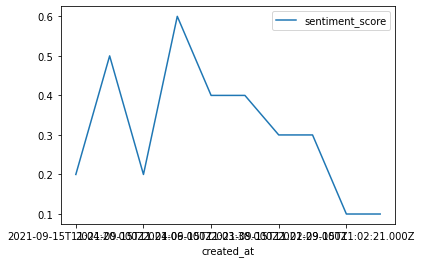

In [5]:
df.plot(x='created_at', y='sentiment_score')